### SCRATCHPAD 
for Trying out modeling with outliers removed from dataset

In [1]:
# Load in libraries
import warnings
from importlib import reload

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np 

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as sms

from statsFunctions import check_model
from statsFunctions import plot_residuals
from statsFunctions import get_columns_correlations 

from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns

In [2]:
# load in data
df = pd.read_csv('../data/prepped_for_price_prediction.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view_rank,...,sqft_living15,sqft_lot15,bed_bath_ratio,date_month,date_day,date_year,renovated_status,sqft_living15_diff,sqft_lot15_diff,scenic_status
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,1340,5650,3.000000,10,13,2014,UNK,-160,0,N
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,1690,7639,1.333333,12,9,2014,Y,880,-397,N
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,2720,8062,2.000000,2,25,2015,UNK,-1950,1938,N
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,1360,5000,1.333333,12,9,2014,UNK,600,0,N
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,...,1800,7503,1.500000,2,18,2015,UNK,-120,577,N


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21015 entries, 0 to 21014
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21015 non-null  int64  
 1   date                21015 non-null  object 
 2   price               21015 non-null  float64
 3   bedrooms            21015 non-null  int64  
 4   bathrooms           21015 non-null  float64
 5   sqft_living         21015 non-null  int64  
 6   sqft_lot            21015 non-null  int64  
 7   floors              21015 non-null  float64
 8   waterfront          21015 non-null  int64  
 9   view_rank           21015 non-null  int64  
 10  condition           21015 non-null  int64  
 11  grade               21015 non-null  int64  
 12  sqft_above          21015 non-null  int64  
 13  sqft_basement       21015 non-null  int64  
 14  yr_built            21015 non-null  int64  
 15  yr_renovated        21015 non-null  int64  
 16  zipc

In [4]:
target = 'price'


<AxesSubplot:>

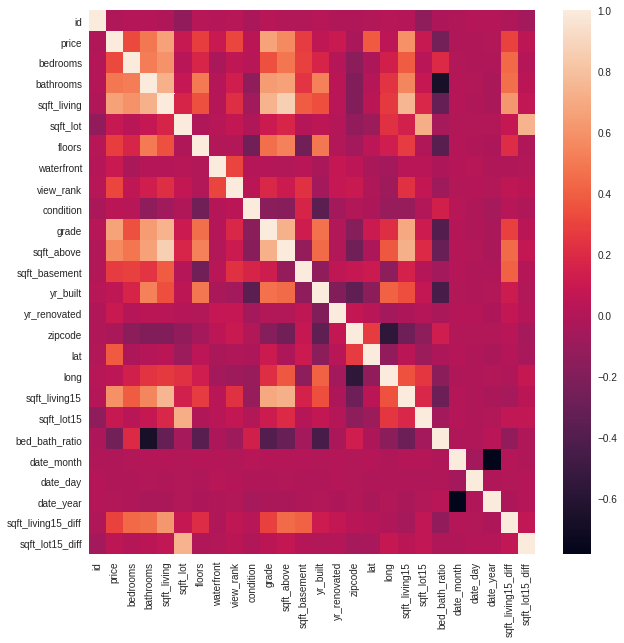

In [5]:
# calculate the correlation matrix
corr = df.corr()

fig, ax = plt.subplots(figsize=(10,10))
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

### BLEH!    Do some log transforms on our skewed continuous variables.
* price, our target, is super skewed
* DROP sqft_living15_diff - it has negative values
* sqft_living15
* lat
* sqft_basement
* sqft_above
* sqft_living


__NOTE__ Distribution for __sqft_living15_diff__ is skewed but it has negative values so we can't try to use log transform to address skew. __OMIT__ from list of continous variables moving forward.



### Categorical variables are:
* bedrooms
* bathrooms
* floors
* view_rank
* waterfront
* grade

<function matplotlib.pyplot.show(close=None, block=None)>

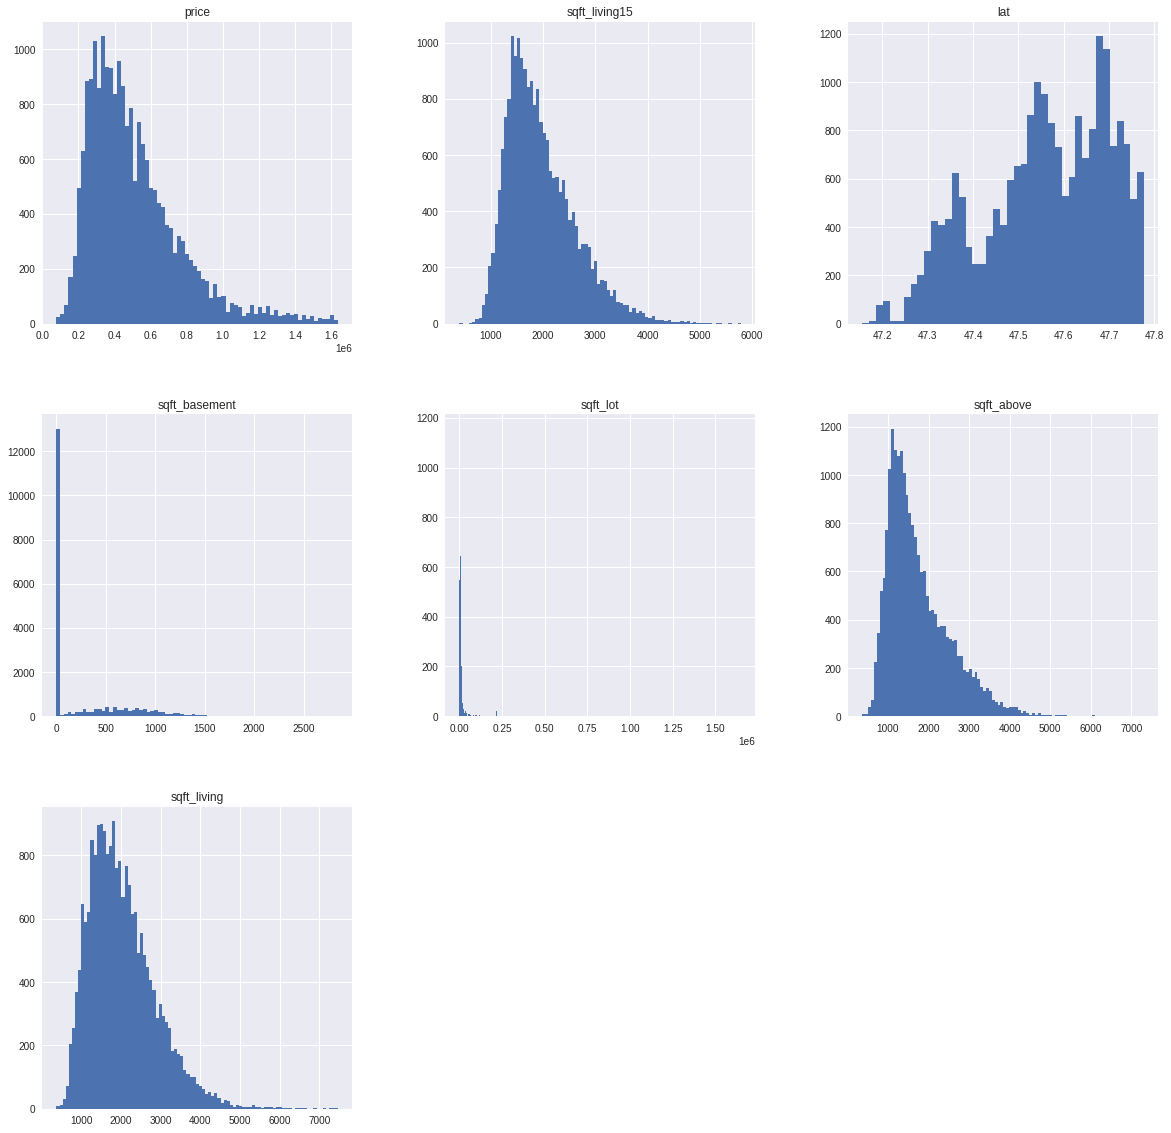

In [6]:
continuous_col_names = ['price','sqft_living15', 'lat', 'sqft_basement', 'sqft_lot', 'sqft_above', 'sqft_living']
continuous_df = df[continuous_col_names]
continuous_df.hist(figsize=[20, 20], bins='auto')
plt.show

In [7]:
# Note that sqft_basement has a huge number of zeros. 
# Drop this zero-inflated variable for now and just use the features which don't have this characteristic. 
continuous_df.drop(['sqft_basement'], axis=1, inplace=True)
continuous_df.head()

,price,sqft_living15,lat,sqft_lot,sqft_above,sqft_living
0,221900.0,1340,47.5112,5650,1180,1180
1,538000.0,1690,47.7210,7242,2170,2570
2,180000.0,2720,47.7379,10000,770,770
3,604000.0,1360,47.5208,5000,1050,1960
4,510000.0,1800,47.6168,8080,1680,1680


### Perform log transformations for those variables that need skew correction
Recall that a common option for transforming non-normal variable distributions is to try applying a logarithmic function and observe its impact of the distribution. Give it a go!


In [8]:
# Now select those variables that need skew correction
non_norm_col_names = ['price','sqft_living15', 'lat', 'sqft_above', 'sqft_living']
non_norm_df = continuous_df[non_norm_col_names]

In [9]:
log_names = [f'{column}_log' for column in non_norm_df.columns]
cont_log_transformed_df = np.log(non_norm_df)
cont_log_transformed_df.columns = log_names
cont_log_transformed_df.head()

,price_log,sqft_living15_log,lat_log,sqft_above_log,sqft_living_log
0,12.309982,7.200425,3.860965,7.073270,7.073270
1,13.195614,7.432484,3.865372,7.682482,7.851661
2,12.100712,7.908387,3.865726,6.646391,6.646391
3,13.311329,7.215240,3.861168,6.956545,7.580700
4,13.142166,7.495542,3.863186,7.426549,7.426549


<function matplotlib.pyplot.show(close=None, block=None)>

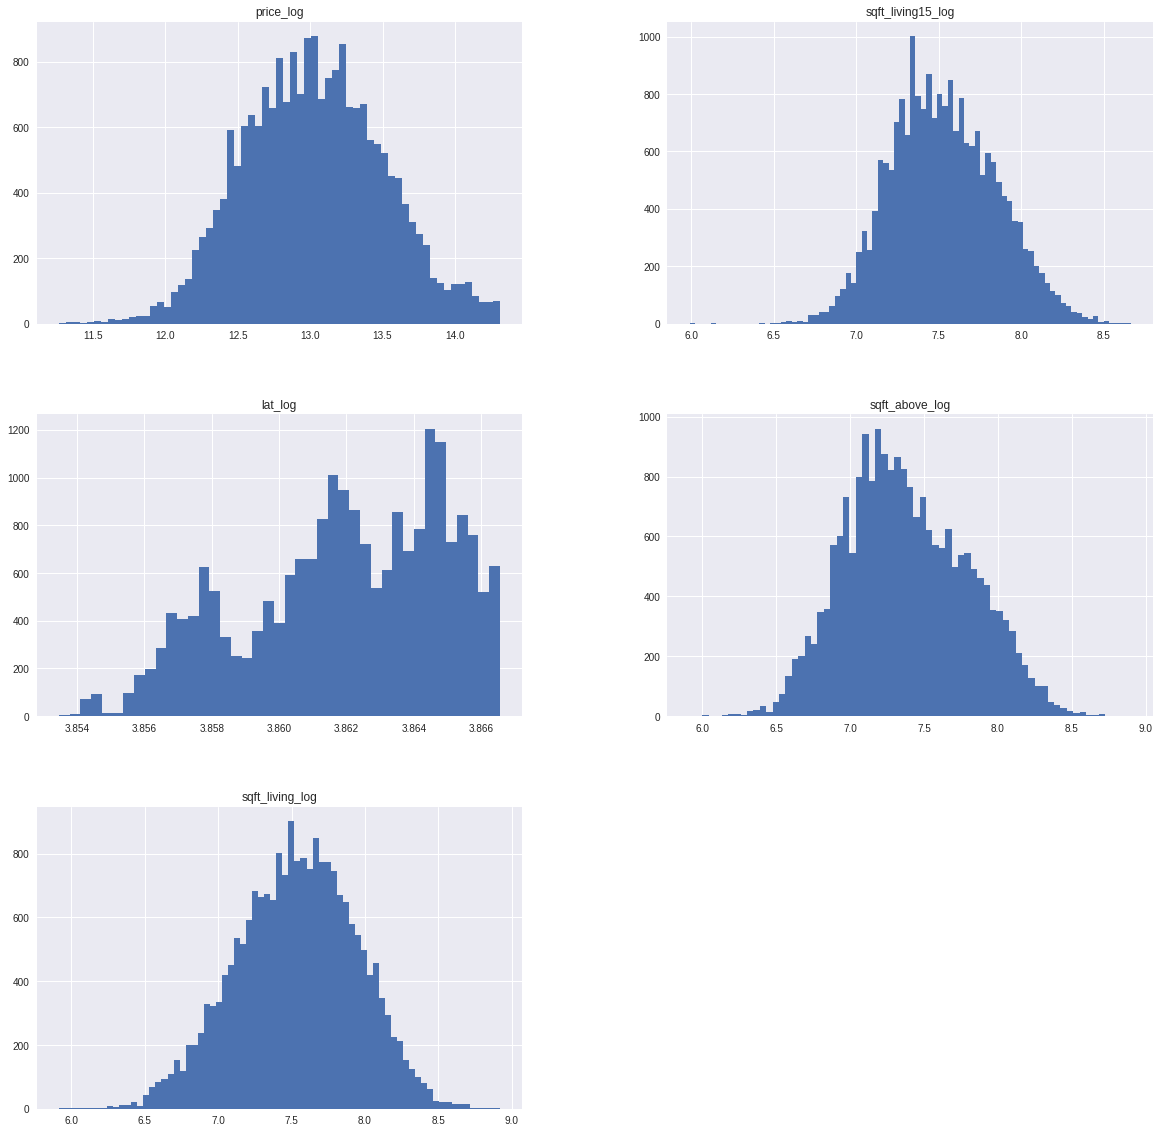

In [10]:
cont_log_transformed_df.hist(figsize=(20, 20), bins='auto')
plt.show

### Inspect the log transformed continuous variable distributions.  If the skew was improved, that variable will be standardized and  included in the final feature space/set.


In [11]:
# normalize function for features that were log transformed
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

# drop features that didn't see skew improvement
cont_log_transformed_df.drop(['lat_log'], axis=1, inplace=True)
cont_log_transformed_df = cont_log_transformed_df.apply(normalize)

<function matplotlib.pyplot.show(close=None, block=None)>

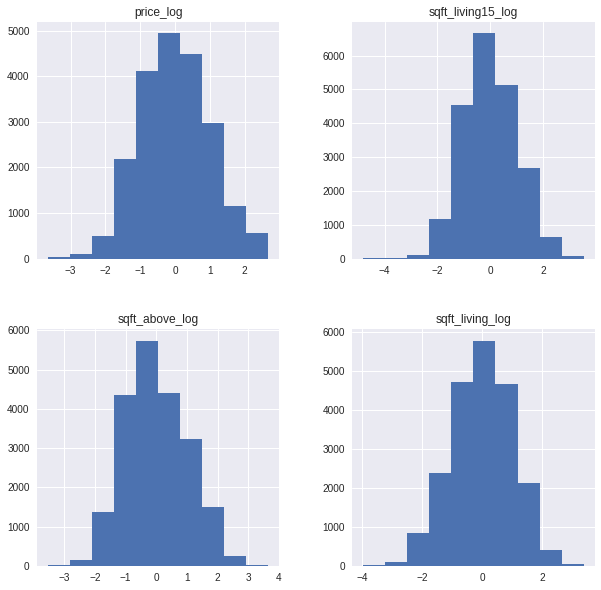

In [12]:
cont_log_transformed_df.hist(figsize=(10, 10))
plt.show

In [13]:
feature_names = [
    'bed_bath_ratio',
    'sqft_living_log',
    'sqft_living15_log',
    'view_rank'
]

In [14]:
orig_with_log_transformed_df = pd.concat([df, cont_log_transformed_df], axis = 1)
ols = check_model(orig_with_log_transformed_df, features_to_use=feature_names, 
                  target_col='price_log', show_summary=True)

                                 OLS Regression Results                                
Dep. Variable:              price_log   R-squared (uncentered):                   0.457
Model:                            OLS   Adj. R-squared (uncentered):              0.457
Method:                 Least Squares   F-statistic:                              4422.
Date:                Fri, 16 Oct 2020   Prob (F-statistic):                        0.00
Time:                        22:16:40   Log-Likelihood:                         -23401.
No. Observations:               21015   AIC:                                  4.681e+04
Df Residuals:                   21011   BIC:                                  4.684e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

### Can we do better?


###  One-hot-encode Categorical variables for potential use


In [15]:
# one-hot encode the categorical variables
categorical_col_names = ['floors', 'view_rank', 'grade', 'condition', 'waterfront']
corr_cat_df = df[categorical_col_names]
corr_cat_df.head()

,floors,view_rank,grade,condition,waterfront
0,1.0,0,7,3,0
1,2.0,0,7,3,0
2,1.0,0,6,3,0
3,1.0,0,7,5,0
4,1.0,0,8,3,0


In [16]:
# DON'T FALL INTO THE DUMMY TRAP!  drop_first=True :)
corr_ohe_df = pd.get_dummies(corr_cat_df, columns=categorical_col_names, prefix=categorical_col_names, drop_first=True)
corr_ohe_df.head()

,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,view_rank_1,view_rank_2,view_rank_3,view_rank_4,grade_4,...,grade_8,grade_9,grade_10,grade_11,grade_12,condition_2,condition_3,condition_4,condition_5,waterfront_1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [17]:
### concat the continous and categorical likely features into a single datafame for model creation
orig_with_logtrans_ohe_df = pd.concat([orig_with_log_transformed_df, corr_ohe_df], axis = 1)

<AxesSubplot:>

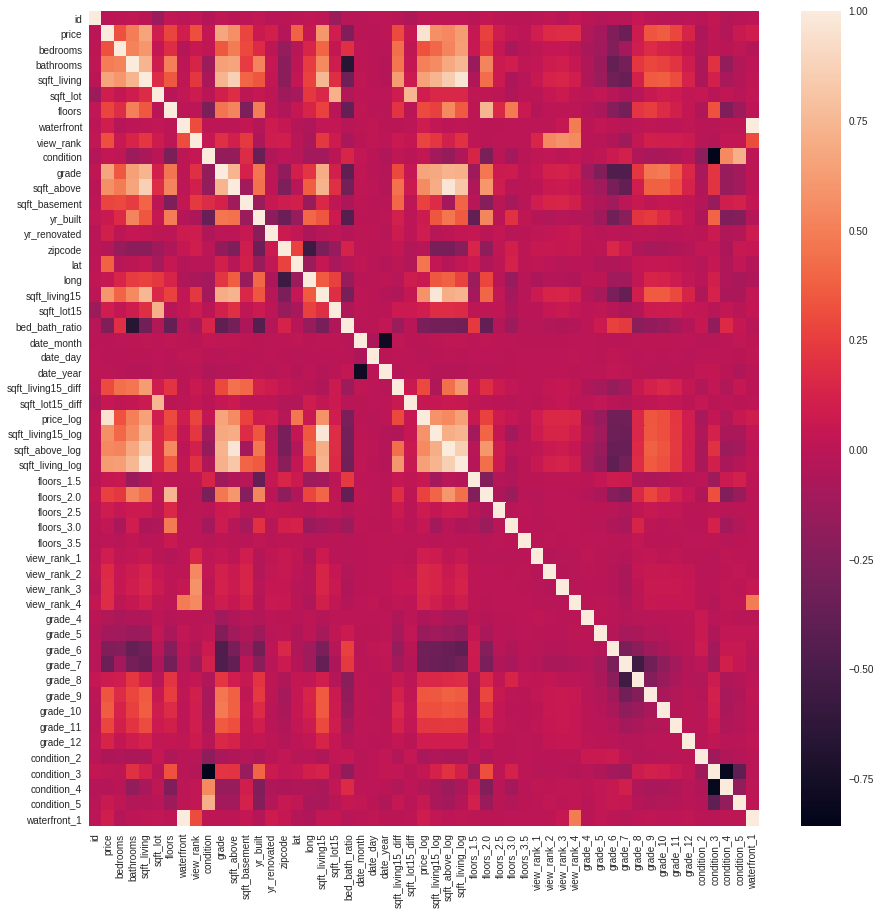

In [18]:
# calculate the correlation matrix
corr2 = orig_with_logtrans_ohe_df.corr()

fig, ax = plt.subplots(figsize=(15,15))
# plot the heatmap
sns.heatmap(corr2, 
        xticklabels=corr2.columns,
        yticklabels=corr2.columns)

In [19]:
feature_names2 = [
'bed_bath_ratio',
'sqft_living_log',
'sqft_living15_log',
'floors_1.5',
'view_rank_1',
'view_rank_2',
'view_rank_3',
'view_rank_4',
'condition_2',
#'condition_3',
'condition_4',
#'condition_5',
'grade_4',
'grade_5',
'grade_6',
#'grade_7',
]

In [20]:
ols2 = check_model(orig_with_logtrans_ohe_df, features_to_use=feature_names2, 
                  target_col='price_log', show_summary=True)

                                 OLS Regression Results                                
Dep. Variable:              price_log   R-squared (uncentered):                   0.476
Model:                            OLS   Adj. R-squared (uncentered):              0.475
Method:                 Least Squares   F-statistic:                              1466.
Date:                Fri, 16 Oct 2020   Prob (F-statistic):                        0.00
Time:                        22:17:37   Log-Likelihood:                         -23034.
No. Observations:               21015   AIC:                                  4.609e+04
Df Residuals:                   21002   BIC:                                  4.620e+04
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

Create some models based on intution

In [21]:
likely_feature_names = [
    'sqft_living15_log',
   # 'sqft_above_log',
    'sqft_living_log',
    'bedrooms_2',
    'bedrooms_3',
    'bedrooms_4',
    'bedrooms_5',
    'bedrooms_6',
    'bedrooms_7',
    'bedrooms_8',
    'bedrooms_9',
    'bedrooms_10',
    'bedrooms_11',
    'bathrooms_0.75',
    'bathrooms_1.0',
    'bathrooms_1.25',
    'bathrooms_1.5',
    'bathrooms_1.75',
    'bathrooms_2.0',
    'bathrooms_2.25',
    'bathrooms_2.5',
    'bathrooms_2.75',
    'bathrooms_3.0',
    'bathrooms_3.25',
    'bathrooms_3.5',
    'bathrooms_3.75',
    'bathrooms_4.0',
    'bathrooms_4.25',
    'bathrooms_4.5',
    'bathrooms_4.75',
    'bathrooms_5.0',
    'bathrooms_5.25',
    'bathrooms_5.5',
    'bathrooms_5.75',
    'bathrooms_6.0',
    'bathrooms_6.5',
    'bathrooms_6.75',
    'bathrooms_7.5',
    #'floors_1.5',
    #'floors_2.0',
    #'floors_2.5',
    #'floors_3.0',
    #'floors_3.5',
    'view_rank_1',
    'view_rank_2',
    'view_rank_3',
    'view_rank_4',
    #'grade_4',
    #'grade_5',
    #'grade_6',
    #'grade_7',
    #'grade_8',
    #'grade_9',
    #'grade_10',
    #'grade_11',
    #'grade_12',
    'condition_2',
    'condition_3',
    'condition_4',
    'condition_5',
    'waterfront_1'
]

### Now that we've got some likely features (continous variables that have been transformed and normalized and categorical variables that have been one-hot-encoded), create another model

In [22]:
ols_round_two = check_model(likely_features_df, features_to_use=likely_feature_names, target_col='price_log', show_summary=True)

NameError: name 'likely_features_df' is not defined

### This new model has multicollinearity. Iterate by removing features.

In [ ]:
likely_feature_names2 = list()
for name in likely_feature_names:
    if name.find('bathrooms') == -1:
        likely_feature_names2.append(name)
likely_feature_names2

In [ ]:
ols_round_3 = check_model(likely_features_df, features_to_use=likely_feature_names2, target_col='price_log', show_summary=True)

#### Now down to just 2 problematic (multicollinear) variables. They make sense too: sqft_living_log  and sqft_above_log

Drop one and do another model iteration

In [ ]:
likely_feature_names3 = likely_feature_names2
likely_feature_names3.remove('sqft_above_log')

In [ ]:
ols_round_4 = check_model(likely_features_df, features_to_use=likely_feature_names3, target_col='price_log', show_summary=True)

####  One more time, with feeling

In [ ]:
likely_feature_names4 = likely_feature_names3
likely_feature_names4.remove('sqft_living_log')
likely_feature_names4

In [ ]:
ols_round_5 = check_model(likely_features_df, features_to_use=likely_feature_names4, target_col='price_log', show_summary=True)

### Welp, this is still not great but I've learned how to go through the process of feature engineering, model building, and model evaluation. :)

* R squared  and Adjusted R squared
    * Both are 0.523 which is not that great
* Omnibus/Prob(Omnibus) – a test of the skewness and kurtosis of the residual. We hope to see a value close to zero which would indicate normalcy. The Prob (Omnibus) performs a statistical test indicating the probability that the residuals are normally distributed. We hope to see something close to 1 here.
    * Omnibus is 3.707 and Prob(Omnibus) is 0.157. I'm not sure how to interpret this but neither value is close to the desired value of 1. The histogram of the residual distributions appears to be normal so I'm really not sure how to interpreet these results.
* Skew – a measure of data symmetry. We want to see something close to zero, indicating the residual distribution is normal.
    * Skew is close to zero, at -0.027, and therefore only slight skew.
* Kurtosis – a measure of "peakiness", or curvature of the data. Higher peaks lead to greater Kurtosis. Greater Kurtosis can be interpreted as a tighter clustering of residuals around zero, implying a better model with few outliers.
    * Kurtosis is 2.963. I'm I'm not entirely sure how to interpret this value/what does 'higher peak' mean?
 * Durbin-Watson – tests for homoscedasticity (characteristic #3). We hope to have a value between 1 and 2. 
    * D-W is 1.972, within range as we can see from the residual plots below.
* Jarque-Bera(JB) – like the Omnibus test in that it tests both skew and kurtosis. We hope to see in this test a confirmation of the Omnibus test.
    * JB is 3.715 seems close to 2.963. I'm not entirely sure how to interpret this value.
* Condition Number – This test measures the sensitivity of a function's output as compared to its inpuput. When there is multicollinearity, we can expect much higher fluctuations to small changes in the data, hence, we hope to see a relatively small number, something below 30. 
    * Cond. No is 158 which is well above 30. So that makes me think this model is not that great.


Big shoutout to Andrea C. for sharing this great resource on understanding the LR results.  https://www.accelebrate.com/blog/interpreting-results-from-linear-regression-is-the-data-appropriate 


In [ ]:
# Plot the residuals to get a visualization of residual distribution and if residuals are homoscedastic
plot_residuals(ols_round_5)

#### The visual checks appear to look good BUT this model does not pass the Shaprio test

In [ ]:
# H0: data is normal
# HA: data is not normal
residuals = ols_round_5.resid
t, p = scs.shapiro(residuals)
print(f't:{t},  p:{p}')
# p = 0.00103 -> reject the null hypothesis, therefore residuals are not normally distributed.

## Look if binning homes into subregions could help.

In [ ]:
zips_by_subregion_df = pd.read_csv('../data/zips_by_subregion.csv')

In [ ]:
zips_by_subregion_df.head()

In [ ]:
len(zips_by_subregion_df['zip'].unique())

In [ ]:
zips_by_subregion_df.info()

In [ ]:
zips_by_subregion_df['sub_region'].unique()

In [ ]:
len(zips_by_subregion_df['sub_region'].unique())